In [67]:
import osmread
import numpy as np
import leuvenmapmatching
from pathlib import Path
import requests
import rtree
import pyproj
import matplotlib.pyplot as plt
import networkx as nx
import math
import random
import logging
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import smopy
import pandas as pd
from pathlib import Path
import requests
import geocoder
import pickle

In [7]:
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.util.gpx import gpx_to_path
from leuvenmapmatching import visualization as mmviz
from leuvenmapmatching import visualization as mm_viz

In [8]:
#парсим XML файл с OpenStreetMap через API, по координатам ограничивающей рамки карты в г. Уфа

xml_file = Path(".") / "my_osm.xml"
url = 'http://overpass-api.de/api/map?bbox=55.852830,54.690987,55.862870, 54.700228'
r = requests.get(url, stream=True)
with xml_file.open('wb') as file_osm:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            file_osm.write(chunk)

In [92]:
#Создаем ориентированный граф дорожной сети (map_con), 
#добавлением узлов ребер (метод .add_edge()) и координат узлов (метод .add_node()) 

map_con = InMemMap("myosm", use_latlon=True, use_rtree=True, index_edges=True)
for drive_osm in osmread.parse_file(str(xml_file)):
    if isinstance(drive_osm, osmread.Way) and 'highway' in drive_osm.tags:
        for node_a, node_b in zip(drive_osm.nodes, drive_osm.nodes[1:]):
            map_con.add_edge(node_a, node_b)
            map_con.add_edge(node_b, node_a)
    if isinstance(drive_osm, osmread.Node):
        map_con.add_node(drive_osm.id, (drive_osm.lat, drive_osm.lon))
map_con.purge()

In [139]:
#для примера, выбираем первые 20 элементов графа
list(map_con.serialize()['graph'].items())[0:20]

[(1096641687, ((54.6831812, 55.8638475), [2303422024, 2303422003])),
 (1211531018, ((54.7009777, 55.8601463), [5198419072])),
 (2303421917, ((54.6863047, 55.8683107), [2303421983, 2303422032])),
 (2303421918, ((54.6942795, 55.8664653), [2303422051, 2303421975])),
 (2303421919, ((54.6868257, 55.8692334), [2303421996, 2303422008])),
 (2303421920, ((54.6966666, 55.8656607), [2303421982, 2303421989])),
 (2303421922, ((54.6877869, 55.8541599), [2303421991, 2303422035])),
 (2303421923, ((54.6853372, 55.8658002), [2303421958, 2303422022])),
 (2303421924, ((54.6844565, 55.8619061), [2303422007, 2303422016])),
 (2303421928, ((54.6847418, 55.8622602), [2303422016, 2303422009])),
 (2303421929, ((54.6910488, 55.8615199), [2303422027, 2303422045])),
 (2303421930, ((54.6977842, 55.8653619), [2303421990, 2303422043])),
 (2303421934, ((54.6997605, 55.8651672), [2303421977])),
 (2303421935, ((54.6851015, 55.8614984), [2303421981, 2303422039])),
 (2303421939, ((54.6887234, 55.8511987), [2303421984, 2303

Lowered zoom level to keep map size reasonable. (z = 15)


(None, <AxesSubplot:xlabel='Longitude', ylabel='Latitude'>)

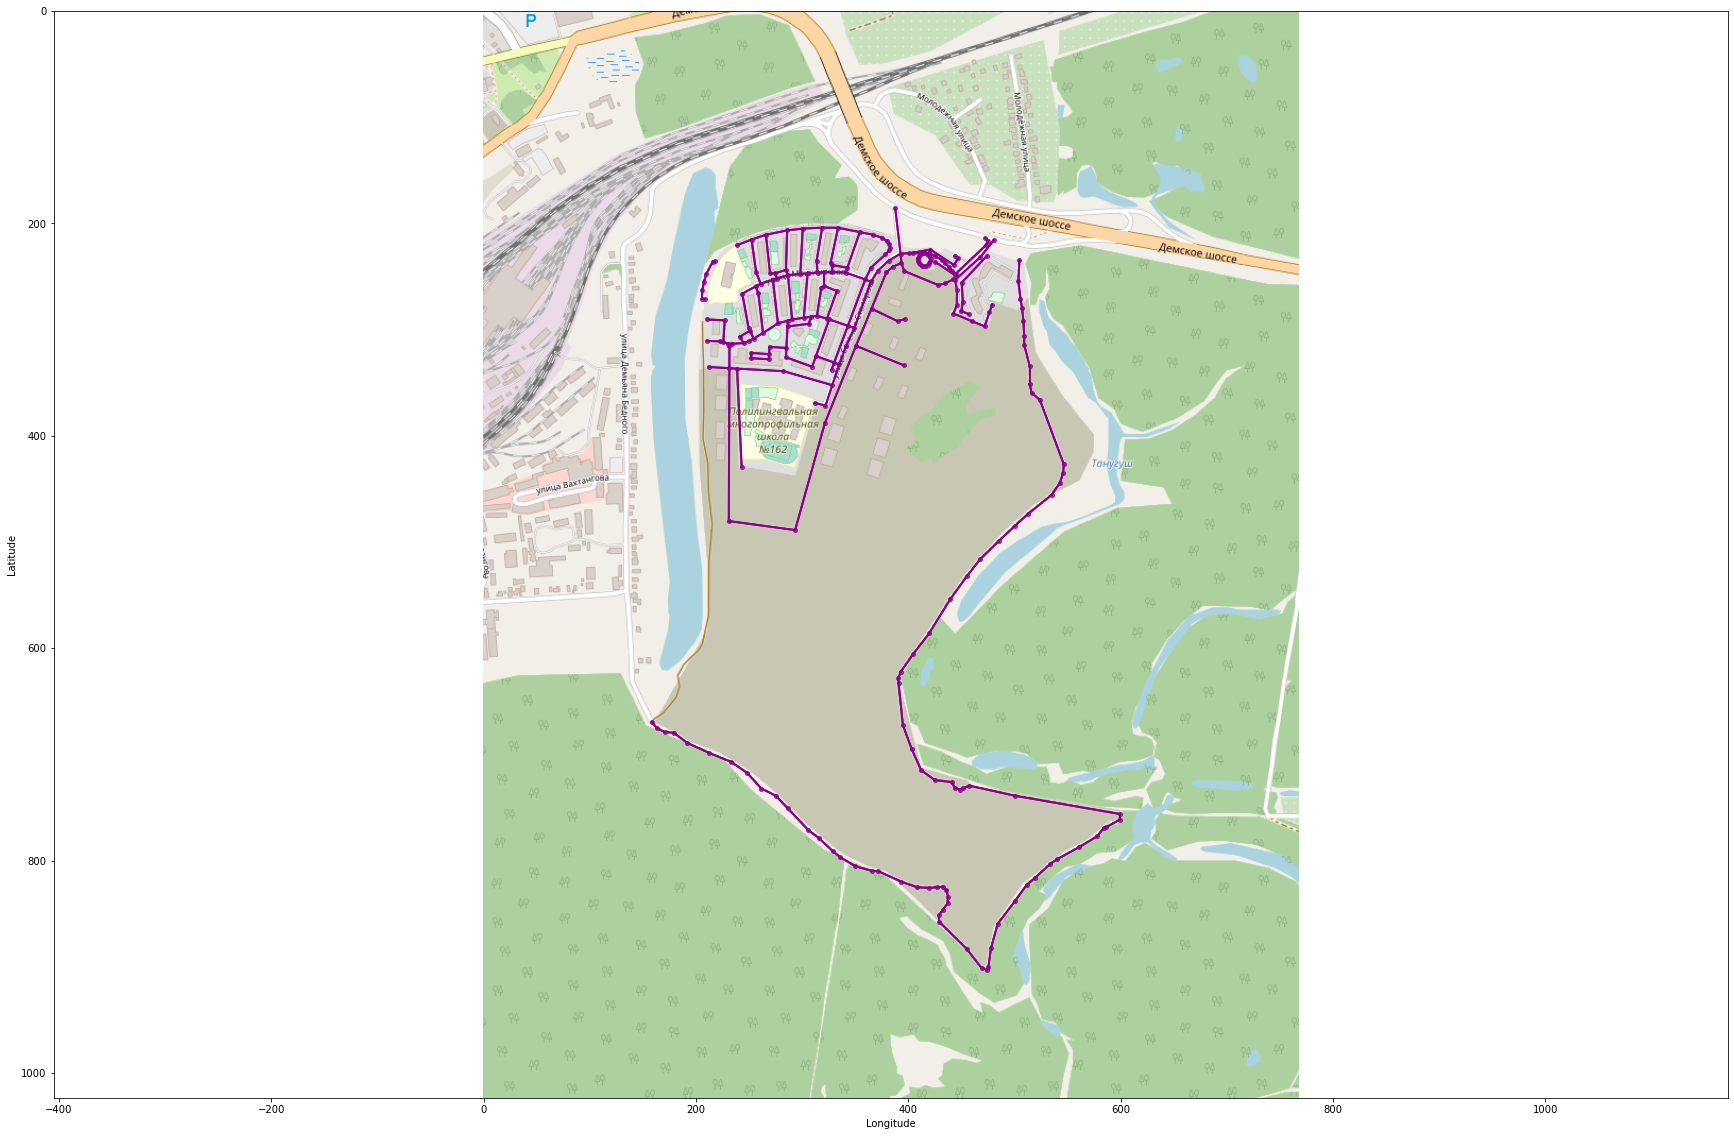

In [46]:
#визуализация дорожной карты графа (при указании use_osm=True, 
#карта OSM отображается в качестве подложки)

fig, ax = plt.subplots(figsize = (30,20))
mmviz.plot_map(map_con,
                use_osm=True, zoom_path=True, ax=ax,
                show_labels=False, show_matching=True, show_graph=True,
                filename="map_graph_osm_plot.png")

In [22]:
#рандомный GPS трек с яндекс карт

track = [(54.698266, 55.856246),
         (54.698244, 55.855948),
         (54.698159, 55.855787), 
         (54.698087, 55.855772),
         (54.697994, 55.855757),
         (54.697922, 55.855735),
         (54.697858, 55.855838),
         (54.697778, 55.855714), 
         (54.697701, 55.855794),
         (54.697672, 55.855640), 
         (54.697701, 55.855472),
         (54.697714, 55.855209),
         (54.697638, 55.855114),
         (54.697579, 55.855092),
         (54.697451, 55.855092),
         (54.697502, 55.854843),
         (54.697468, 55.854690),
         (54.697485, 55.854565)]

In [23]:
# Выбор наиболее вероятного ребра из графа

matcher = DistanceMatcher(map_con, max_dist=80, 
                          max_dist_init=30, 
                          min_prob_norm=0.001, 
                          non_emitting_length_factor=0.75, 
                          obs_noise=50, 
                          obs_noise_ne=80, 
                          non_emitting_states=True)
states, _ = matcher.match(track)

In [9]:
matcher.print_lattice_stats()
print(states)

Stats lattice
-------------
nbr levels               : 18
nbr lattice              : 658
avg lattice[level]       : 36.55555555555556
min lattice[level]       : 14
max lattice[level]       : 46
avg obs distance         : 2.5570425951435354
last logprob             : -0.06388065316905944
last length              : 18
last norm logprob        : -0.003548925176058858
[(8777008079, 8777008080), (8777008079, 8777008080), (8777008080, 8777008024), (8777008080, 8777008024), (8777008080, 8777008024), (8777008080, 8777008024), (8777008080, 8777008024), (8777008080, 8777008024), (8777008080, 8777008024), (8777008024, 8777008023), (8777008024, 8777008023), (8777008024, 8777008023), (8777008023, 8777008019), (8777008023, 8777008019), (8777008019, 8777008022), (8777008022, 8777008021), (8777008022, 8777008021), (8777008022, 8777008021)]


Lowered zoom level to keep map size reasonable. (z = 17)


(None, <AxesSubplot:xlabel='Longitude', ylabel='Latitude'>)

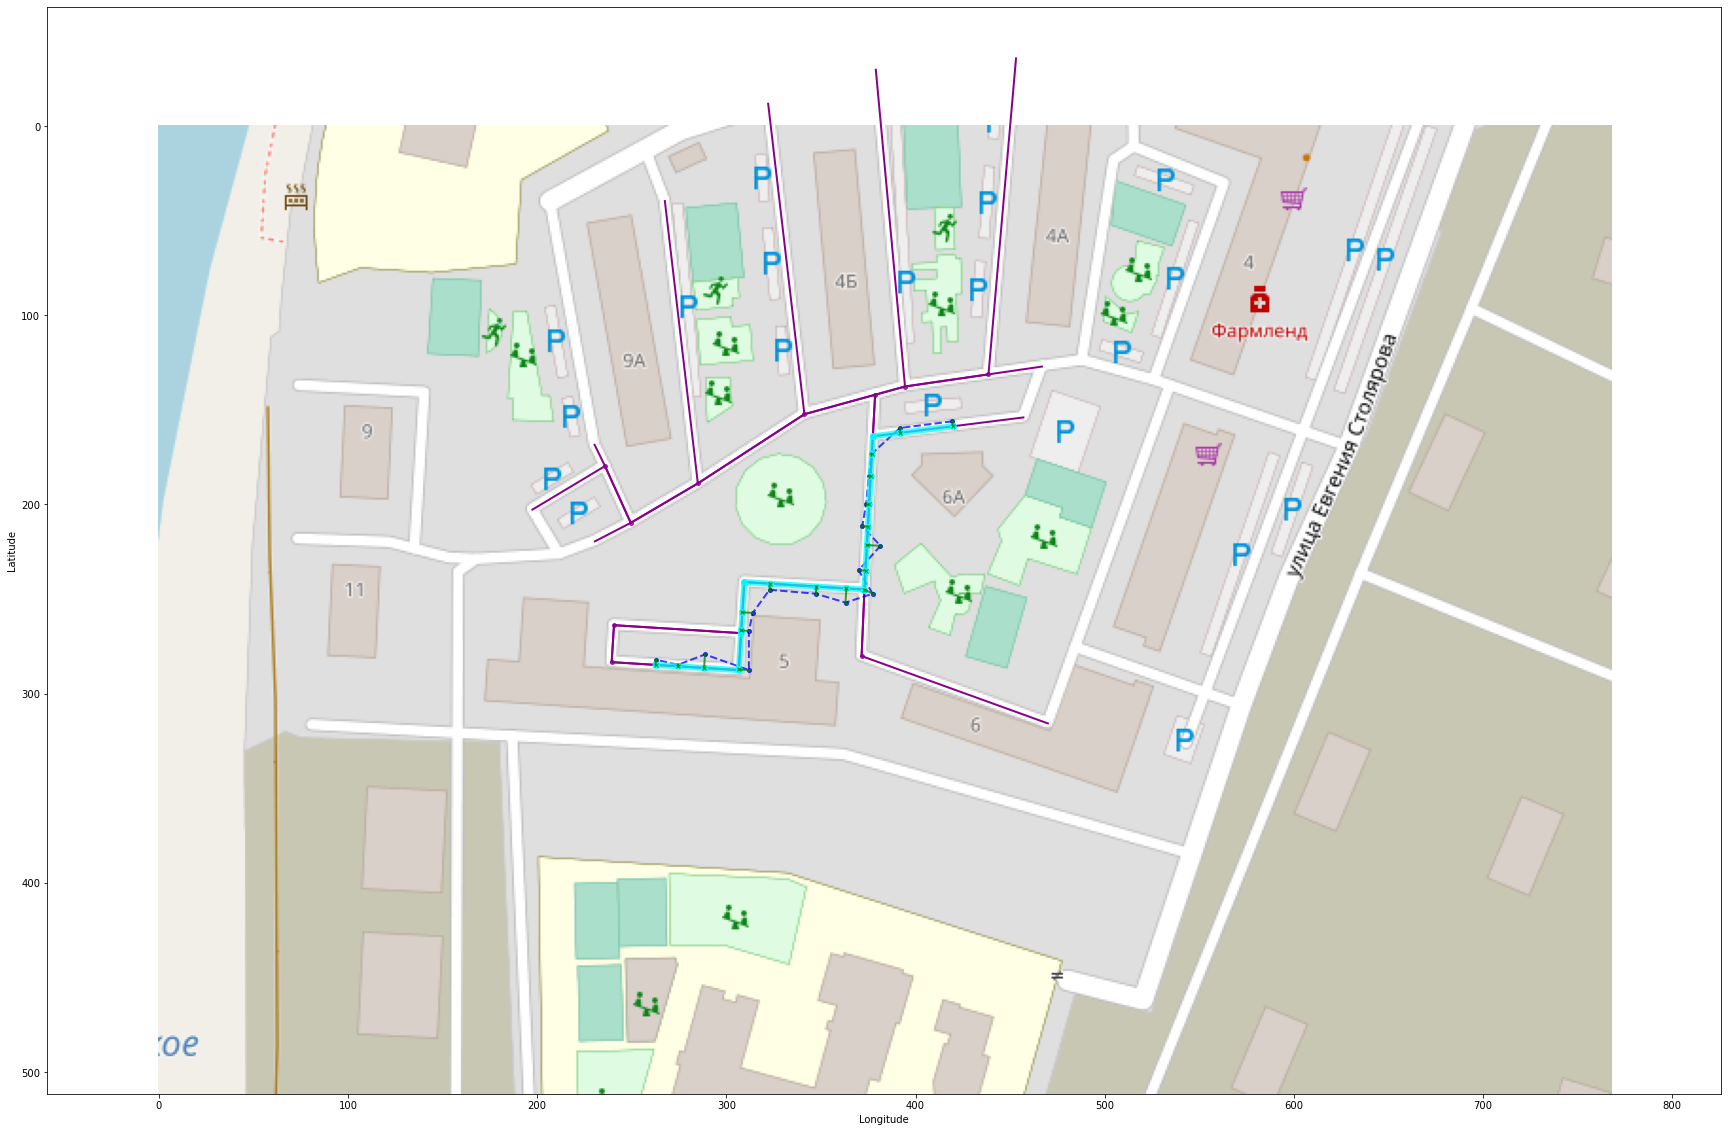

In [10]:
#визуализация метода - зеленые проекции на наиболее вероятное ребро графа дорожной сети, отображение маршрута (светло-синий)
#в основе лежит стохастическая модель, описывающая последовательность возможных событий, 
#в которых вероятность каждого события зависит только от состояния, достигнутого в предыдущем событии, 
#т.к. одна GPS координата может иметь проекции на несколько ребер графа
#отображение графа дорог (фиолетовый) на карте OSM

fig, ax = plt.subplots(figsize = (30,20))
mmviz.plot_map(map_con,matcher=matcher,
                use_osm=True, zoom_path=True, ax=ax,
                show_labels=False, show_matching=True, show_graph=True,
                filename="HMM_method_osm_plot.png")

In [12]:
#Датафрейм принадлежности координат и дорог (ребер графа дорожной сети)

list_t = list(zip(states,track))

result = pd.DataFrame(list_t, columns=['id_node_highway', 'GPS_track'])
result

,id_node_highway,GPS_track
0,"(8777008079, 8777008080)","(54.698266, 55.856246)"
1,"(8777008079, 8777008080)","(54.698244, 55.855948)"
2,"(8777008080, 8777008024)","(54.698159, 55.855787)"
3,"(8777008080, 8777008024)","(54.698087, 55.855772)"
4,"(8777008080, 8777008024)","(54.697994, 55.855757)"
5,"(8777008080, 8777008024)","(54.697922, 55.855735)"
6,"(8777008080, 8777008024)","(54.697858, 55.855838)"
7,"(8777008080, 8777008024)","(54.697778, 55.855714)"
8,"(8777008080, 8777008024)","(54.697701, 55.855794)"
9,"(8777008024, 8777008023)","(54.697672, 55.85564)"


In [13]:
gps_node_s = []
for node_s, node_e in result['id_node_highway']:
    gps_node_s.append([tuple(map_con.node_coordinates(node_s))] + [tuple(map_con.node_coordinates(node_e))])

In [18]:
result['GPS_node_highway'] = gps_node_s
result

,id_node_highway,GPS_track,GPS_node_highway
0,"(8777008079, 8777008080)","(54.698266, 55.856246)","[(54.6982787, 55.8566487), (54.6982169, 55.855..."
1,"(8777008079, 8777008080)","(54.698244, 55.855948)","[(54.6982787, 55.8566487), (54.6982169, 55.855..."
2,"(8777008080, 8777008024)","(54.698159, 55.855787)","[(54.6982169, 55.8557951), (54.6977147, 55.855..."
3,"(8777008080, 8777008024)","(54.698087, 55.855772)","[(54.6982169, 55.8557951), (54.6977147, 55.855..."
4,"(8777008080, 8777008024)","(54.697994, 55.855757)","[(54.6982169, 55.8557951), (54.6977147, 55.855..."
5,"(8777008080, 8777008024)","(54.697922, 55.855735)","[(54.6982169, 55.8557951), (54.6977147, 55.855..."
6,"(8777008080, 8777008024)","(54.697858, 55.855838)","[(54.6982169, 55.8557951), (54.6977147, 55.855..."
7,"(8777008080, 8777008024)","(54.697778, 55.855714)","[(54.6982169, 55.8557951), (54.6977147, 55.855..."
8,"(8777008080, 8777008024)","(54.697701, 55.855794)","[(54.6982169, 55.8557951), (54.6977147, 55.855..."
9,"(8777008024, 8777008023)","(54.697672, 55.85564)","[(54.6977147, 55.8557475), (54.6977393, 55.855..."
